# Лабораторная работа №2

Выполнил студент группы М8О-110M-21 Куликов А. В.

#### Постановка задачи
Необходимо для кальция (Ca) определить постоянную решётки и энергию когезии и провести идентификацию параметров уравнения состояния Бёрча-Мурнагана на не менее чем девяти точках.

#### Метод решения

Импортируем необходимые библиотеки

In [1]:
import os
import shutil
import matplotlib.pyplot as plt

import subprocess as sps
import numpy as np

Определяем базовый класс для вычислений с помощью Quantum Espresso. В нем реализуется функциональность для записи конфигурационных файлов, запуска вычислений и кеширования результатов.

In [2]:
class BaseComputation:
    def __init__(self, element_name, ibrav, A, ecutwfc, coef, atomic_weight, k):
        self.element_name = element_name
        self.ibrav = ibrav
        self.A = A
        self.ecutwfc = ecutwfc
        self.coef = coef
        self.atomic_weight = atomic_weight
        self.k = k
        self.pseudopotential_name = BaseComputation.__pick_appropriate_pseudopotential(element_name)
        self.__res_directory_path = None

    def result_directory_path(self):
        if self.__res_directory_path is None:
            self.__res_directory_path = self.result_directory_path_prefix() \
                + f'_launch_{self.element_name}_{self.ibrav}_{self.A}_{self.ecutwfc}_' \
                + f'{self.coef}_{self.atomic_weight}_{self.k}'
        
        return self.__res_directory_path

    def result_directory_path_prefix(self):
        raise NotImplementedError

    @staticmethod
    def __pick_appropriate_pseudopotential(element_name):
        pps = os.listdir('/home/alex/QuantumEspresso/sssp/')

        for pp in pps:
            if pp.startswith(element_name):
                return pp

        raise Exception(f'Could not pick appropriate pseudopotential for element "{element_name}"')

    def gen_config(self, out_dir):
        raise NotImplementedError

    def write_config_file(self, config_file_path, out_dir):
        with open(os.path.join(out_dir, config_file_path), 'w') as f:
            cfg = self.gen_config(out_dir)
            f.write(cfg)

    def run_pw(self, out_path, n_jobs):
        input_file = os.path.join(self.result_directory_path(), 'pw_in.txt')
        if n_jobs == 1:
            command = ['pw.x', '-in', input_file]
        else:
            command = ['mpirun', '--hostfile', 'hostfile', '-np', '8', 'pw.x', '-in', input_file]

        print(f'Running: {" ".join(command)}')

        pw_out = sps.check_output(command).decode('utf-8')
                
        with open(os.path.join(out_path, 'pw_out.txt'), 'w') as logfile:
            logfile.writelines(pw_out)

        return pw_out.splitlines()

    def restore_result(self):
            with open(os.path.join(self.result_directory_path(), 'pw_out.txt'), 'r') as logfile:
                log = logfile.read().splitlines()
                return self.fetch_result_from_log(log)

    def restore_if_already_computed(self):
        try:
            if os.path.isdir(self.result_directory_path()):
                result = self.restore_result()
                if result is not None:
                    return result
        except:
            shutil.rmtree(self.result_directory_path())
        return None

    def run(self, verbose=False, n_jobs=1):
        result = self.restore_if_already_computed()
        if result is not None:
            return result

        os.mkdir(self.result_directory_path())
        self.write_config_file('pw_in.txt', self.result_directory_path())

        pw_output = self.run_pw(self.result_directory_path(), n_jobs)

        if verbose:
            for line in pw_output:
                print(line)
        
        result = self.fetch_result_from_log(pw_output)

        if result is None:
            raise Exception('Required data not found')

        return result

    def fetch_result_from_log(self, log):
        raise NotImplementedError


Определяем базовый класс для самосогласованных вычислений. В нем реализуется парсинг результат работы pw.x с целью извлечения рассчитанной общей энергии кристаллической решетки.

In [3]:
class SCFComputation(BaseComputation):
    def __init__(self, element_name, ibrav, A, ecutwfc, coef, atomic_weight, k):
        super().__init__(element_name, ibrav, A, ecutwfc, coef, atomic_weight, k)

    def gen_config(self, out_dir):
        return f"""&control
    calculation = 'scf'
    prefix = 'scf'
    pseudo_dir = '/home/alex/QuantumEspresso/sssp/'
    outdir = '{out_dir}/out/'
/
&system
    ibrav = {self.ibrav}
    A = {self.A}
    nat = 1
    ntyp = 1
    ecutwfc = {self.ecutwfc}
    ecutrho = {self.coef * self.ecutwfc}
/
&electrons
/
ATOMIC_SPECIES
    {self.element_name} {self.atomic_weight} {self.pseudopotential_name}
ATOMIC_POSITIONS crystal
    {self.element_name} 0.0 0.0 0.0
K_POINTS automatic
    {self.k} {self.k} {self.k} 0 0 0
"""
    def fetch_result_from_log(self, log):
        for line in log:
            if line.startswith('!'):
                parts = [part for part in line.split(' ') if len(part) > 0]
                return float(parts[4])
        return None
                

Определяем класс для самосогласованных вычислений над полной решеткой.

In [4]:
class SolidSCFComputation(SCFComputation):
    def __init__(self, element_name, ibrav, A, ecutwfc, coef, atomic_weight, k):
        super().__init__(element_name, ibrav, A, ecutwfc, coef, atomic_weight, k)

    def result_directory_path_prefix(self):
        return 'solid_scf'

    def gen_config(self, out_dir):
        return f"""&control
    calculation = 'scf'
    prefix = 'solid'
    pseudo_dir = '/home/alex/QuantumEspresso/sssp/'
    outdir = '{out_dir}/out/'
/
&system
    ibrav = {self.ibrav}
    A = {self.A}
    nat = 1
    ntyp = 1
    ecutwfc = {self.ecutwfc}
    ecutrho = {self.coef * self.ecutwfc}
/
&electrons
/
ATOMIC_SPECIES
    {self.element_name} {self.atomic_weight} {self.pseudopotential_name}
ATOMIC_POSITIONS crystal
    {self.element_name} 0.0 0.0 0.0
K_POINTS automatic
    {self.k} {self.k} {self.k} 0 0 0
"""

Задаем параметры материала для проведения рассчетов

In [5]:
element_name = 'Ca'     # элемент кальций (Ca)
ibrav = 2               # гранецентричекая кубическая решетка

A = 5.5884              # постоянная решетки
atomic_weight = 40.078  # атомная масса

coef = 8                # коэффициент зависимости энергии отсечения потенциала ecutrho
                        # от энергии отсечения для волновых функций ecutwfc

Для различных $k$ и $e_{cutwfc}$ рассчитываем полные энергии решетки для определения $k$ и $e_{cutwfc}$, при которых достигается необходимая для дальнейших рассчетов точность вычислений

In [6]:
ks = np.array(list(range(4, 12)))
ecutwfcs = np.array(list(range(30, 120, 10)))

energies = []

for k in ks:
    energies.append([])
    for ecutwfc in ecutwfcs:
        c = SolidSCFComputation(element_name, ibrav, A, ecutwfc, coef, atomic_weight, k)
        energies[-1].append(c.run(n_jobs=8))

energies = np.array(energies)

Ищется такая комбинация $k$ и $e_{cutwfc}$, дальнейшее увеличение которых не приводит к сильному изменению (более $3 \cdot 10^{-5}$) вычисленных полных энергий решетки. Точность $3 \cdot 10^{-5}$ задается вместо указанной в задании $10^{-3}$, потому что при точности $10^{-3}$ не получалось с достаточной степенью точности рассчитать $C_{44}$ в следующей лабораторной работе.

Строим графики зависимости энергии от $k$ и $e_{cutwfc}$

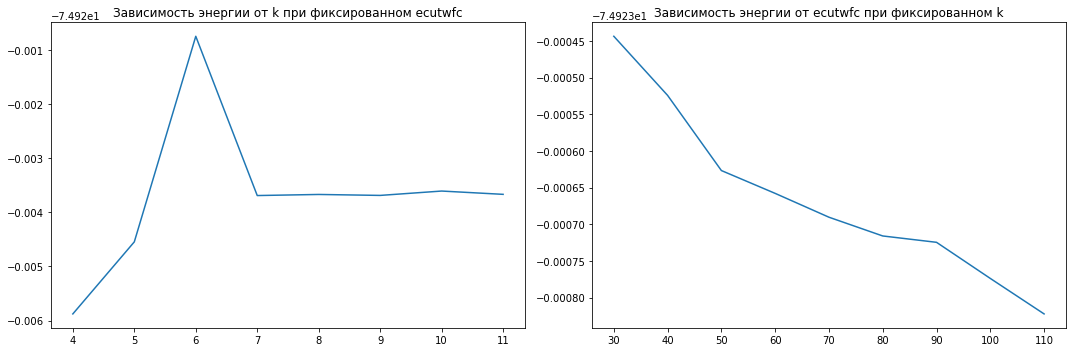

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(ks, energies[:, 4])
ax1.set_title('Зависимость энергии от k при фиксированном ecutwfc')
ax2.plot(ecutwfcs, energies[3])
ax2.set_title('Зависимость энергии от ecutwfc при фиксированном k')

plt.tight_layout()
print()

In [8]:
k=9
ecutwfc=100

Определяем класс для конфигурации и вызова вычислений с релаксацией решетки с возможностью изменения ячейки. В качестве результата этих вычисления выступает поправочный коэффициент для получения из эталонной постоянной решетки, такой оптимальной постоянной решетки, которая наиболее точно удовлетворяет модели, рассчитываемой в Quantum Espresso при заданном псевдопотенциале. 

In [9]:
class VCRelaxComputation(BaseComputation):
    def __init__(self, element_name, ibrav, A, ecutwfc, coef, atomic_weight, k):
        super().__init__(element_name, ibrav, A, ecutwfc, coef, atomic_weight, k)

    def result_directory_path_prefix(self):
        return 'vc_relax'

    def gen_config(self, out_dir):
        return f"""&control
    calculation = 'vc-relax'
    prefix = 'vc_relax'
    pseudo_dir = '/home/alex/QuantumEspresso/sssp/'
    outdir = '{out_dir}/out/'
/
&system
    ibrav = {self.ibrav}
    A = {self.A}
    nat = 1
    ntyp = 1
    ecutwfc = {self.ecutwfc}
    ecutrho = {self.coef * self.ecutwfc}
    occupations = 'smearing'
    smearing = 'cold'
    degauss = 0.02
/
&electrons
    conv_thr = 1.d-8
/
&ions
/
&cell
/
ATOMIC_SPECIES
    {self.element_name} {self.atomic_weight} {self.pseudopotential_name}
ATOMIC_POSITIONS crystal
    {self.element_name} 0.0 0.0 0.0
K_POINTS automatic
    {self.k} {self.k} {self.k} 0 0 0
""" 

    def fetch_result_from_log(self, log):
        line_index = -1
        for i, line in enumerate(reversed(log)):
            if line.startswith('CELL_PARAMETERS'):
                line_index = len(log) - 1 - i
                break

        if line_index == -1:
            return None

        return -float([part for part in log[line_index + 1].split(' ') if len(part) > 0][0]) / (0.5)

Вычисление оптимальной постоянной решетки путем релаксирования с возможностью изменения размеров ячейки.

In [10]:
c = VCRelaxComputation(element_name, ibrav, A, ecutwfc, coef, atomic_weight, k)

A_coef = c.run(n_jobs=8)
A = A_coef * A 
print(f'{A_coef=}')
print(f'Постоянная решетки {A=}')

A_coef=0.988031906
Постоянная решетки A=5.5215175034904


Вычисление полной энергии решетки при оптимальной постоянной решетки.

In [11]:
c = SolidSCFComputation(element_name, ibrav, A, ecutwfc, coef, atomic_weight, k)
e_solid = c.run(n_jobs=8)

print(f'Энергия полной энергии решетки (в Ридбергах): {e_solid}')

Энергия полной энергии решетки (в Ридбергах): -74.92414029


Определяем класс для рассчета энергии изолированного атома. Процесс вычисления энергии изолированного атома оличается от вычисления энергии полной решетки отличается несколькими особенностями:
- Необходимо учитывать намагниченность атома. Для учета магнетизации нужно в конфигурационнм файле указать параметры `occupations = 'fixed'`, `nspin = 2` и `tot_magnetization`, равный числу неспаренных электронов на внешних орбиталях атома (для кальция их число равно 0).
- Quantum Espresso не предназначен для рассчетов для изолированных атомов, все рассчеты проводятся в бесконечных периодическах кристаллических решетках. Поэтому, чтобы "сымитрировать" изолированность атома постоянная решетки задается значительно большей, чем настоящая, например 20 ангстрем.
- Также, для ускорения рассчетов, в Quantum Espresso существует специальный тип сетки `gamma` с одной точкой. 

In [12]:
class IsolatedSCFComputation(SCFComputation):
    def __init__(self, element_name, ibrav, A, ecutwfc, coef, atomic_weight, k, total_magnetization):
        super().__init__(element_name, ibrav, A, ecutwfc, coef, atomic_weight, k)
        self.total_magnetization = total_magnetization

    def result_directory_path_prefix(self):
        return 'isolated_scf'

    def gen_config(self, out_dir):
        return f"""&control
    calculation = 'scf'
    prefix = 'isolated'
    pseudo_dir = '/home/alex/QuantumEspresso/sssp/'
    outdir = '{out_dir}/out/'
/
&system
    ibrav = {self.ibrav}
    A = {self.A}
    nat = 1
    ntyp = 1
    ecutwfc = {self.ecutwfc}
    ecutrho = {self.coef * self.ecutwfc}
    occupations = 'fixed'
    nspin = 2
    tot_magnetization = {self.total_magnetization}
/
&electrons
/
ATOMIC_SPECIES
    {self.element_name} {self.atomic_weight} {self.pseudopotential_name}
ATOMIC_POSITIONS crystal
    {self.element_name} 0.0 0.0 0.0
K_POINTS gamma
"""

Производим рассчет энергии изолированного атома

In [13]:
total_magnetization = 0
c = IsolatedSCFComputation(element_name, 1, 20.0, min(ecutwfc, 70), coef, atomic_weight, min(k, 7), total_magnetization)

e_isolated = c.run(n_jobs=4)
print(f'Энергия изолированного атома (в Ридбергах): {e_isolated}')

Энергия изолированного атома (в Ридбергах): -74.78486777


Вводим вспомогательные функции для перевода между физическими величинами. 

In [14]:
# Перевод из Ридбергов в электрон-вольты
def rydberg_to_electron_volt(e_ry):
    return 13.6056980659 * e_ry

# Перевод из электрон-вольт в Ридберги 
def electron_volt_rydberg(e_ev):
    return e_ev / 13.6056980659

# Перевод из электрон-вольт/ангстрем в гигапаскали 
def eV_Angstrom_to_GPa(ev_a):
    return ev_a * 160.21766208

# Перевод из гигапаскалей в электрон-вольт/ангстрем
def GPa_to_eV_Angstrom(gpa):
    return gpa / 160.21766208

Вычисляем энергию когезии (в эВ) как разницу между полной энергией решетки и энергией изолированного атома  

In [15]:
e_coh = rydberg_to_electron_volt(e_solid - e_isolated)
print(f'Когезионная энергия: {e_coh}')

Когезионная энергия: -1.8948998559969046


Определяем класс для проведения самосогласованных вычислений с задаваемым базисом 

In [16]:
class SolidSCFComputatioBasis(SCFComputation):
    def __init__(self, element_name, ibrav, A, ecutwfc, coef, atomic_weight, k, basis):
        super().__init__(element_name, ibrav, A, ecutwfc, coef, atomic_weight, k)
        self.basis = basis

    def get_basis_vec_by_index(self, i):
        return f'{self.basis[i][0]} {self.basis[i][1]} {self.basis[i][2]}'

    def result_directory_path_prefix(self):
        return f'solid_scf_basis_{self.get_basis_vec_by_index(0)}_{self.get_basis_vec_by_index(1)}_' \
            + f'{self.get_basis_vec_by_index(2)}'

    def gen_config(self, out_dir):
        return f"""&control
    calculation = 'scf'
    prefix = 'solid_scf_basis'
    pseudo_dir = '/home/alex/QuantumEspresso/sssp/'
    outdir = '{out_dir}/out/'
/
&system
    ibrav = {self.ibrav}
    A = {self.A}
    nat = 1
    ntyp = 1
    ecutwfc = {self.ecutwfc}
    ecutrho = {self.coef * self.ecutwfc}
    occupations = 'smearing'
    smearing = 'cold'
    degauss = 0.02
/
&electrons
    conv_thr = 1.d-8
/
ATOMIC_SPECIES
    {self.element_name} {self.atomic_weight} {self.pseudopotential_name}
ATOMIC_POSITIONS crystal
    {self.element_name} 0.0 0.0 0.0
K_POINTS automatic
    {self.k} {self.k} {self.k} 0 0 0
CELL_PARAMETERS alat
    {self.get_basis_vec_by_index(0)}
    {self.get_basis_vec_by_index(1)}
    {self.get_basis_vec_by_index(2)}
"""

Вводим уравение состояния Бёрча-Мурнагана и вспомогательные функции для генерации ограничений грядущей задачи оптимизации

In [17]:
from scipy.optimize import curve_fit

# базис по-умолчанию, совпадает по смыслу с базисом, испольуемым в Quantum Espresso при ibrav=2
default_basis = np.array([[0, 0.5, 0.5], [0.5, 0, 0.5], [0.5, 0.5, 0]])

v_coef = 0.25   # т.к. объем примитивной решетки специального вида (которую используем для ускорения вычислений)
                # отличается от объема элементарной ГЦК решетки, для вычисления объема будет использован этот 
                # коэффициент

# функция для вычисления объема ячейки
def volume(A):
    return A ** 3

# Уравнение состояния Бёрча-Мурнагана
def eos(v, ev0, v0, b0, db0_dp):
    eta = (v / v0) ** (1.0 / 3.0)
    E = ev0 + 9.0 * b0 * v0 / 16.0 * (eta ** 2 - 1.0) ** 2 * (6.0 + db0_dp * (eta ** 2 - 1.0) - 4.0 * eta ** 2)
    return E

# вспомогательная функция для отступа от значения на некоторый процент
def offset(value, percent):
    return (1 + percent / 100) * value

Вычисляем значения энергий при разных объемах решетки

In [18]:
volumes = []
energies = []
for i in range(-5, 6):
    # постоянная решетки после применения деформации (не передается в качестве постоянной решетки в рассчет, 
    # т.к. деформация для рассчета достигается изменением длин базисных векторов, а используется 
    # только для рассчета объема ячейки)
    A_cur = offset(A, i)                 
    cur_basis = offset(default_basis, i) # базис после применения деформации
    c = SolidSCFComputatioBasis(element_name, 0, A, ecutwfc, coef, atomic_weight, k, cur_basis)

    energies.append(rydberg_to_electron_volt(c.run(n_jobs=8)))
    volumes.append(volume(A_cur) * v_coef)

volumes = np.array(volumes)
energies = np.array(energies)

print(f'{energies=}')

energies=array([-1019.351566  , -1019.37341811, -1019.38991788, -1019.40138762,
       -1019.40813673, -1019.41046657, -1019.40866708, -1019.40301908,
       -1019.39379006, -1019.38124425, -1019.36562491])


Производим фиттинг уравнения состояния по ранее рассчитанным значениям энергий

In [19]:
### 1-й способ ###
ev0_offset_percentage = 5
v0_offset_percentage = 5
b0_offset_percentage = 50

b0_ref = GPa_to_eV_Angstrom(17)

lower_bound = np.array([offset(rydberg_to_electron_volt(e_solid), ev0_offset_percentage),
                        offset(volume(A) * v_coef, -v0_offset_percentage),
                        offset(b0_ref, -b0_offset_percentage),
                        -np.inf])

upper_bound = np.array([offset(rydberg_to_electron_volt(e_solid), -ev0_offset_percentage),
                        offset(volume(A) * v_coef, v0_offset_percentage),
                        offset(b0_ref, b0_offset_percentage),
                        np.inf])

bounds = lower_bound, upper_bound

p0 = np.concatenate([(lower_bound[:-1] + upper_bound[:-1]) / 2, np.array([0])])

popt, pcov = curve_fit(eos, volumes, energies, p0=p0, method='trf', bounds=bounds, maxfev=10000)

######

### 2-й способ ###
# В первом приближении фитим простую параболу
# a, b, c = np.polyfit(volumes, energies, 2)

# Затем вычисляем приближенные значения основных параметров для настоящего уравнения состояния Бёрча-Мурнагана.
# V0 = -b/(2*a)
# E0 = a*V0**2 + b*V0 + c
# B0 = 2*a* V0
# Bp = 4.0

# Используя вычисленные начальные приближения параметров в качестве стартовой точки для оптимизации
# p0 = np.array([E0, V0, B0, Bp])

# проводим фиттинг уравнения состояния Бёрча-Мурнагана.
# popt, pcov = curve_fit(eos, volumes, energies, p0=p0)

######

# получаем рассчитанные оптимальные параметры уравнения состояния
ev0, v_temp, b0_temp, db0_dp = popt

# на основе оптимальных параметров, с учетом нестандартной решетки, применяемой для рассчетов, 
# получаем истинные значения балк-модуля (в ГПа) и равновесного объема  
b0 = eV_Angstrom_to_GPa(b0_temp)

print(f'Оптимальные параметры: E_0: {ev0}, V_0: {v_temp}, B_0: {b0}, dB_0/dP: {db0_dp}')

Оптимальные параметры: E_0: -1019.4105729896634, V_0: 42.150546460505495, B_0: 17.6861623362929, dB_0/dP: 0.7314273850047358


В результате фиттинга уравнения состояния получаем для него следующие значения оптимальных параметров:

 | Параметр | Значение |
|-|-|
 | $E_{0}$ | -1019.4169692447616 |
 | $V_{0}$ | 42.13615169019406 |
 | $B_{0}$ | 17.758934871924936 |
 | $\frac{\partial B_{0}}{\partial P}$ | 0.6590151000408409 |

Полученное значение балк-модуля $B_{0}$ близко к справочному, поэтому можно утверждать, что фиттинг уравнения состояния проведен верно. 

Строим график уравнения состояния с вычисленными оптимальными параметрами

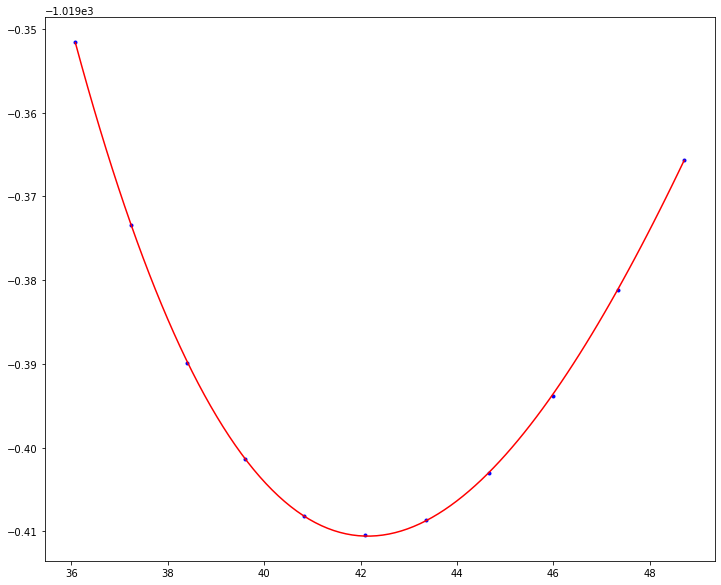

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))

# Строим точки рассчитанной зависимости полной энергии решетки от объема ячейки
ax.plot(volumes, energies, 'b.')

v = np.linspace(min(volumes), max(volumes), 100)
e = eos(v, ev0, v_temp, b0_temp, db0_dp)

# Строим график уравнение состояния после фиттинга
ax.plot(v, e, 'r-')
print()

#### Выводы
В ходе выполнения данной лабораторной работы для кальция (Ca) были определены постоянная решётки и энергия когезии. Так же была проведена идентификация параметров уравнения состояния Бёрча-Мурнагана на не менее чем девяти точках.

# Лабораторная работа №3
Выполнил студент группы М8О-110M-21 Куликов А. В.

#### Постановка задачи

Для кальция (Ca) вычислить модуль объёмной упругости $B$ и константы упругости $С_{11}$, $С_{22}$, $С_{33}$, $С_{44}$, $С_{55}$, $С_{66}$, $С_{12}$, $С_{13}$, $С_{23}$.

#### Метод решения


Определяем функции для генерации матриц деформаций для рассчета констант упругости

In [21]:
# Матрица деформаций для вычисления балк-модуля
def DB_mat(alpha):
    q = 1 + alpha
    return np.array([[q, 0, 0],
                     [0, q, 0], 
                     [0, 0, q]])

# Матрица деформаций для вычисления С11
def DC11_mat(alpha):
    q = 1 + alpha
    return np.array([[q, 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]])

# Матрица деформаций для вычисления С22
def DC22_mat(alpha):
    q = 1 + alpha
    return np.array([[1, 0, 0],
                     [0, q, 0],
                     [0, 0, 1]])

# Матрица деформаций для вычисления С33
def DC33_mat(alpha):
    q = 1 + alpha
    return np.array([[1, 0, 0], 
                     [0, 1, 0],
                     [0, 0, q]])

In [22]:
# Матрица деформаций для вычисления С44
def DC44_mat(alpha):
    q = 1 / (1 - alpha ** 2) ** (1 / 3)
    aq = alpha * q
    return np.array([[q, 0, 0],
                     [0, q, aq], 
                     [0, aq, q]])

# Матрица деформаций для вычисления С55
def DC55_mat(alpha):
    q = 1 / (1 - alpha ** 2) ** (1 / 3)
    aq = alpha * q
    return np.array([[q, 0, aq], 
                     [0, q, 0], 
                     [aq, 0, q]])

# Матрица деформаций для вычисления С66
def DC66_mat(alpha):
    q = 1 / (1 - alpha ** 2) ** (1 / 3)
    aq = alpha * q
    return np.array([[q, aq, 0],
                     [aq, q, 0],
                     [0, 0, q]])


In [23]:
# Матрица деформаций для вычисления С12
def DC12_mat(alpha):
    q = 1 / (1 - alpha ** 2) ** (1 / 3)
    qp = (1 + alpha) / (1 - alpha ** 2) ** (1 / 3)
    qm = (1 - alpha) / (1 - alpha ** 2) ** (1 / 3)
    return np.array([[qp, 0, 0], 
                     [0, qm, 0],
                     [0, 0, q]])

# Матрица деформаций для вычисления С13
def DC13_mat(alpha):
    q = 1 / (1 - alpha ** 2) ** (1 / 3)
    qp = (1 + alpha) / (1 - alpha ** 2) ** (1 / 3)
    qm = (1 - alpha) / (1 - alpha ** 2) ** (1 / 3)
    return np.array([[qp, 0, 0],
                     [0, q, 0],
                     [0, 0, qm]])

# Матрица деформаций для вычисления С23
def DC23_mat(alpha):
    q = 1 / (1 - alpha ** 2) ** (1 / 3)
    qp = (1 + alpha) / (1 - alpha ** 2) ** (1 / 3)
    qm = (1 - alpha) / (1 - alpha ** 2) ** (1 / 3)
    return np.array([[q, 0, 0],
                     [0, qp, 0],
                     [0, 0, qm]])

Определяем функцию для численного рассчета второй производной некоторой функции

In [24]:
def deriv2(x, func, h=0.01):
    fp = func(x + h)
    f = func(x)
    fm = func(x - h)

    return (fp - 2 * f + fm) / (h * h)

Определяем класс для вычисления констант упругости. В нем реализованы методы дял вычисления всех констант упругости + балк-модуля при помощи вычисления второй производной полной энергии решетки, деформированной при помощи соответствующих матриц деформации.

In [25]:
class StiffnesCoefficientsEstimator:
    def __init__(self, A, v_coef, h=0.01):
        self.A = A
        self.h = h

        self.v0 = A ** 3 * v_coef

    def compute_energy(self, alpha, mat_func):
        deformation_matrix = mat_func(alpha)
        basis = [deformation_matrix @ vector for vector in default_basis]

        c = SolidSCFComputatioBasis(element_name, 0, self.A, ecutwfc, coef, atomic_weight, k, basis)

        return rydberg_to_electron_volt(c.run(n_jobs=8))

    def compute_B(self):
        return eV_Angstrom_to_GPa(1 / (9 * self.v0) * deriv2(0, lambda alpha: self.compute_energy(alpha, DB_mat)))

    def compute_C11(self):
        return eV_Angstrom_to_GPa(1 / self.v0 * deriv2(0, lambda alpha: self.compute_energy(alpha, DC11_mat)))

    def compute_C22(self):
        return eV_Angstrom_to_GPa(1 / self.v0 * deriv2(0, lambda alpha: self.compute_energy(alpha, DC22_mat)))

    def compute_C33(self):
        return eV_Angstrom_to_GPa(1 / self.v0 * deriv2(0, lambda alpha: self.compute_energy(alpha, DC33_mat)))

    def compute_C44(self):
        return eV_Angstrom_to_GPa(1 / (4 * self.v0) * deriv2(0, lambda alpha: self.compute_energy(alpha, DC44_mat)))

    def compute_C55(self):
        return eV_Angstrom_to_GPa(1 / (4 * self.v0) * deriv2(0, lambda alpha: self.compute_energy(alpha, DC55_mat)))

    def compute_C66(self):
        return eV_Angstrom_to_GPa(1 / (4 * self.v0) * deriv2(0, lambda alpha: self.compute_energy(alpha, DC66_mat)))

    def compute_C12(self):
        return eV_Angstrom_to_GPa(1 / (2 * self.v0) * deriv2(0, lambda alpha: self.compute_energy(alpha, DC11_mat) \
            + self.compute_energy(alpha, DC22_mat) - self.compute_energy(alpha, DC12_mat)))

    def compute_C13(self):
        return eV_Angstrom_to_GPa(1 / (2 * self.v0) * deriv2(0, lambda alpha: self.compute_energy(alpha, DC11_mat) \
            + self.compute_energy(alpha, DC33_mat) - self.compute_energy(alpha, DC13_mat)))

    def compute_C23(self):
        return eV_Angstrom_to_GPa(1 / (2 * self.v0) * deriv2(0, lambda alpha: self.compute_energy(alpha, DC22_mat) \
            + self.compute_energy(alpha, DC33_mat) - self.compute_energy(alpha, DC23_mat)))

Вычисления констант упругости

In [26]:
estimator = StiffnesCoefficientsEstimator(A, v_coef)

B = estimator.compute_B()
print(f'{B=}')
C11 = estimator.compute_C11()
print(f'{C11=}')
C22 = estimator.compute_C22()
print(f'{C22=}')
C33 = estimator.compute_C33()
print(f'{C33=}')
C44 = estimator.compute_C44()
print(f'{C44=}')
C55 = estimator.compute_C55()
print(f'{C55=}')
C66 = estimator.compute_C66()
print(f'{C66=}')
C12 = estimator.compute_C12()
print(f'{C12=}')
C13 = estimator.compute_C13()
print(f'{C13=}')
C23 = estimator.compute_C23()
print(f'{C23=}')

B=17.467551675273324
C11=21.51703086202991
C22=21.51703086202991
C33=21.522210701076425
C44=14.045120176757742
C55=14.045120176757742
C66=14.045120176757742
C12=15.31676943563937
C13=15.31935935732672
C23=15.31935935732672


In [27]:
estimated_values = dict(
    B=B,
    C11=C11,
    C22=C22,
    C33=C33,
    C44=C44,
    C55=C55,
    C66=C66,
    C12=C12,
    C13=C13,
    C23=C23,
)

reference_values = dict(
    B=17,
    C11=21,
    C22=21,
    C33=21,
    C44=14,
    C55=14,
    C66=14,
    C12=15,
    C13=15,
    C23=15
)

def print_row(items):
    print('', *items, sep=' | ', end=' |\n')

def print_rule(n):
    print('|-' * n + '|')

def print_table(reference_values, estimated_values):
    cols = ['Величина', 'Справочное значение', 'Рассчитанное значение', 'Абсолютная погрешность', 'Относительная погрешность']
    print_row(cols)
    print_rule(len(cols))
    for key in reference_values:
        ref = reference_values[key]
        est = estimated_values[key]
        print_row([key, ref, est, abs(est-ref), abs(est-ref)/abs(ref)])

print_table(reference_values, estimated_values)

 | Величина | Справочное значение | Рассчитанное значение | Абсолютная погрешность | Относительная погрешность |
|-|-|-|-|-|
 | B | 17 | 17.467551675273324 | 0.46755167527332375 | 0.02750303972196022 |
 | C11 | 21 | 21.51703086202991 | 0.5170308620299089 | 0.02462051723951947 |
 | C22 | 21 | 21.51703086202991 | 0.5170308620299089 | 0.02462051723951947 |
 | C33 | 21 | 21.522210701076425 | 0.5222107010764248 | 0.024867176241734512 |
 | C44 | 14 | 14.045120176757742 | 0.045120176757741604 | 0.0032228697684101144 |
 | C55 | 14 | 14.045120176757742 | 0.045120176757741604 | 0.0032228697684101144 |
 | C66 | 14 | 14.045120176757742 | 0.045120176757741604 | 0.0032228697684101144 |
 | C12 | 15 | 15.31676943563937 | 0.31676943563937066 | 0.021117962375958043 |
 | C13 | 15 | 15.31935935732672 | 0.3193593573267197 | 0.021290623821781315 |
 | C23 | 15 | 15.31935935732672 | 0.3193593573267197 | 0.021290623821781315 |


#### Результаты расчетов

После проведения рассчетов получаем следующие результаты:

 | Величина | Справочное значение | Рассчитанное значение | Абсолютная погрешность | Относительная погрешность |
|-|-|-|-|-|
| B | 17 | 17.467551675273324 | 0.46755167527332375 | 0.02750303972196022 |
 | C11 | 21 | 21.51703086202991 | 0.5170308620299089 | 0.02462051723951947 |
 | C22 | 21 | 21.51703086202991 | 0.5170308620299089 | 0.02462051723951947 |
 | C33 | 21 | 21.522210701076425 | 0.5222107010764248 | 0.024867176241734512 |
 | C44 | 14 | 14.045120176757742 | 0.045120176757741604 | 0.0032228697684101144 |
 | C55 | 14 | 14.045120176757742 | 0.045120176757741604 | 0.0032228697684101144 |
 | C66 | 14 | 14.045120176757742 | 0.045120176757741604 | 0.0032228697684101144 |
 | C12 | 15 | 15.31676943563937 | 0.31676943563937066 | 0.021117962375958043 |
 | C13 | 15 | 15.31935935732672 | 0.3193593573267197 | 0.021290623821781315 |
 | C23 | 15 | 15.31935935732672 | 0.3193593573267197 | 0.021290623821781315 |

Видно, что значения полученные в результате рассчетов отличаются от соответствующих справочных не более чем на 2.5%, что, в принципе, является неплохим результатом, учитывая простоту вычислений.

#### Выводы
В ходе данной лабораторной работы были рассчитаны константы упругости для кальция (Ca) при помощи квантово-механических расчетах с использованием пакета Quantum Espresso. Полученные результаты совпадают со справочными данными с достаточной степенью точности.

# Лабораторная работа №4

Выполнил студент группы М8О-110M-21 Куликов А. В.

Необходимо провести идентификацию параметров потенциалов, таким образом чтобы полученный потенциал воспроизводил свойства вашего материала, рассчитанные при помощи квантовомеханических расчётов. Сохраните несколько различных наборов параметров с наименьшим средним квадратичным отклонением.

In [29]:
# задаем элементарную ячейку позициями атомов в координатах обычной квадратной решетки
unit_cell = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])

# число повторений элементарной ячейки по каждой из осей x, y, z для формирования супер-ячейки, 
# на которой и будет производиться рассчет
repetitions = 6

# функция для "размножения" ячейки по всемнаправлениям
def repeat_cell(cell, repetitions):
    return np.vstack([cell + np.array([[i, j, k]]) for i in range(repetitions) \
        for j in range(repetitions) for k in range(repetitions)]) / repetitions

super_cell = repeat_cell(unit_cell, repetitions)
print(super_cell)

[[0.         0.         0.        ]
 [0.         0.08333333 0.08333333]
 [0.08333333 0.         0.08333333]
 ...
 [0.83333333 0.91666667 0.91666667]
 [0.91666667 0.83333333 0.91666667]
 [0.91666667 0.91666667 0.83333333]]


Определяем класс, отвечающий за вычисление энергии решетки используя в качестве потенциала RGL-потенциал. Т.к. каждая каждая элементарная ячейка полностью эквивалентна любой другой, рассчет взаимодействий проводится только между каждым 4-х атомов элементарной решетки и всеми остальными атомами в радиусе отсечения. Это позволяет значительно сократить время расчета потенциала.

In [30]:
class EnergyEstimatorRGLPotentialFast:
    def __init__(self, cell, lattice_constant, cutoff, a, xi, p, q, r0, R, D):
        self.cell = cell
        self.lattice_constant = lattice_constant
        self.cutoff = cutoff
        self.a = a
        self.xi = xi
        self.p = p
        self.q = q
        self.r0 = r0
        self.R = R
        self.D = D

    def __call__(self, matrix):
        energy = 0

        start_i = 0
        end_i = start_i + 4

        for i in range(start_i, end_i):
            E_A = 0
            E_R = 0
            for j in range(self.cell.shape[0]):
                if i == j:
                    continue

                d = self.cell[i] - self.cell[j]
                direction = matrix @ (np.remainder(d + 0.5, 1) - 0.5)
                
                r = np.linalg.norm(direction) * self.lattice_constant

                if r > self.cutoff:
                    continue

                z = r / self.r0 - 1

                exp = np.exp(-self.p * z)
                fc = self.f_c(r)

                E_A += fc * self.a * exp

                exp = np.exp(-2 * self.q * z)
                E_R += fc * (self.xi ** 2) * exp

            energy += E_A - np.sqrt(E_R)

        return energy / 2

    def f_c(self, r):
        if r < self.R - self.D:
            return 1
        elif self.R - self.D <= r and r < self.R + self.D:
            return 0.5 * (1 - np.sin(0.5 * np.pi * (r - self.R) / self.D))
        else:
            return 0

Определяем класс для вычисления функции общей ошибки по пяти параметрам: $E_{coh}$, $B$, $C_{11}$, $C_{44}$, $C_{12}$. Ошибкой выступает сумма квадратов относительных погрешностей по этим параметрам.

In [31]:
class LossFunctionalFast:
    def __init__(self, cell, properties):
        self.cell = cell
        self.R = properties['R']
        self.D = properties['D']
        self.repetitions = properties['repetitions']
        self.lattice_constant = properties['lattice_constant'] * self.repetitions
        self.cutoff = properties['cutoff']
        self.E_coh = properties['E_coh']
        self.B = properties['B']
        self.c11 = properties['c11']
        self.c12 = properties['c12']
        self.c44 = properties['c44']
        self.eps = properties['eps']
        self.eps_sq = self.eps**2

        self.volume = properties['lattice_constant'] ** 3

        self.__init_deformation_matrices()

    def __init_deformation_matrices(self):
        self.matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=float)

        self.DB_mat_minus = DB_mat(-self.eps)
        self.DB_mat_plus = DB_mat(self.eps)

        self.DC11_mat_minus = DC11_mat(-self.eps)
        self.DC11_mat_plus = DC11_mat(self.eps)

        self.DC12_mat_minus = DC12_mat(-self.eps)
        self.DC12_mat_plus = DC12_mat(self.eps)

        self.DC44_mat_minus = DC44_mat(-self.eps)
        self.DC44_mat_plus = DC44_mat(self.eps)

        self.DC22_mat_minus = DC22_mat(-self.eps)
        self.DC22_mat_plus = DC22_mat(self.eps)

    def __call__(self, params, print_error_contributions=False):
        a, xi, p, q, r0 = params

        energy_estimator = EnergyEstimatorRGLPotentialFast(self.cell, self.lattice_constant, \
                            self.cutoff, a, xi, p, q, r0, self.R, self.D)

        energy_base = energy_estimator(self.matrix)

        energy_b_low = energy_estimator(self.DB_mat_minus)
        energy_b_high = energy_estimator(self.DB_mat_plus)

        energy_c11_low = energy_estimator(self.DC11_mat_minus)
        energy_c11_high = energy_estimator(self.DC11_mat_plus)
        
        energy_c12_low = energy_estimator(self.DC12_mat_minus)
        energy_c12_high = energy_estimator(self.DC12_mat_plus)

        energy_c44_low = energy_estimator(self.DC44_mat_minus)
        energy_c44_high = energy_estimator(self.DC44_mat_plus)

        energy_c22_low = energy_estimator(self.DC22_mat_minus)
        energy_c22_high = energy_estimator(self.DC22_mat_plus)

        E_coh_cur = energy_base / 4

        B_cur = eV_Angstrom_to_GPa((energy_b_low - 2 * energy_base + energy_b_high) \
            / (self.eps_sq * 9 * self.volume))

        c11_cur = eV_Angstrom_to_GPa((energy_c11_low - 2 * energy_base + energy_c11_high) \
            / (self.eps_sq * self.volume))
            
        c44_cur = eV_Angstrom_to_GPa((energy_c44_low - 2 * energy_base + energy_c44_high) \
            / (self.eps_sq * 4 * self.volume))

        c12_cur = eV_Angstrom_to_GPa(((energy_c11_low + energy_c22_low - energy_c12_low) \
            - 2 * energy_base + (energy_c11_high + energy_c22_high - energy_c12_high)) \
            / (self.eps_sq * 2 * self.volume))

        E_coh_rel_error = ((self.E_coh - E_coh_cur) / abs(self.E_coh))
        B_rel_error = ((B - B_cur) / abs(B))
        c11_rel_error = ((self.c11 - c11_cur) / abs(self.c11))
        c44_rel_error = ((self.c44 - c44_cur) / abs(self.c44))
        c12_rel_error = ((self.c12 - c12_cur) / abs(self.c12))

        if print_error_contributions:
            print('Error contributions: ')
            print(f'E_coh relative error: {abs(E_coh_rel_error)}')
            print(f'B relative error: {abs(B_rel_error)}')
            print(f'C11 relative error: {abs(c11_rel_error)}')
            print(f'C44 relative error: {abs(c44_rel_error)}')
            print(f'C12 relative error: {abs(c12_rel_error)}')

        error = E_coh_rel_error ** 2 + B_rel_error ** 2 \
            + c11_rel_error ** 2 + c44_rel_error ** 2 + c12_rel_error ** 2

        return error

##### Подбор параметров $R$, $D$, $r_{cutoff}$

В описании хода работы указано, что параметры $R$, $D$ и $r_{cutoff}$ потенциала следует подобрать таким образом, чтобы при вычислении потенциала для конкретного атома в зону до отсечения попадали 4-5 ближайших соседей. Для этого посчитаем все возможные расстояния между атомами для заведомо большей (в смысле с большим числом повторений элементарной ячейки) ячейки. 

In [32]:
def distances(cell, lattice_constant):
    dst = set()
    min_d = float('inf')
    for i, atom1 in enumerate(cell):
        for j, atom2 in enumerate(cell):
            if i == j:
                continue
            
            d = np.sqrt(((atom1 - atom2) ** 2).sum()) * lattice_constant
            if d < min_d:
                min_d = d
            
            dst.add(d)
    
    return sorted(dst)

Среди таких расстояний найдем 5 минимальных. И затем определим минимальное расстояние до 5-го ближайшего соседа. 

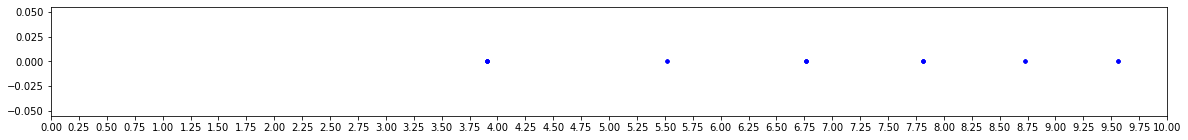

In [33]:
dists = distances(super_cell, A * repetitions)

dists = list(filter(lambda x: x < 10, dists))

fig, ax = plt.subplots(figsize=(20, 2))

ax.plot(dists, np.full(len(dists), 0), 'b.')
ax.xaxis.set_ticks(np.linspace(0.0, 10, 41))
print()

Видно, что 5-й ближайший сосед находится на расстоянии чуть меньшем, чем 8.75 ангстрем. Отметим это расстояние вертикальной линией. В графическом калькуляторе Desmos построим зависимость отсекающей функции от расстояния, и подберем такие параметры $R$ и $D$, чтобы отсекающая функция была равна 1 везде до расстояния до 5-го ближайшего соседа включительно, а затем начинала плавно уменьшаться к 0. Это достигается при $R=9.2$, $D=0.5$. 
![Подбор параметров для отсекающей функции](cutoff_function.png)

$r_{cutoff}$, в свою очередь, должен быть таким, чтобы отсекающая функция могла быть вычислялась везде, до тех пор, пока ее значение не равно 0. Поэтому примем $r_cutoff=9.7$

Посчитаем новое необходимое число повторений элементарной ячеки, чтобы ячейка удовлетворяла следующему условию:
- Необходимо чтобы при расчётах все пары атомов взаимодействовали только единожды, то есть чтобы из всех периодических образов какого либо атома, только один из образов находился внутри радиуса отсечения для любого другого атома.
Этого можно добиться повторив элементарную ячейку несколько раз во всех направлениях, таким образом чтобы длина стороны ячейки была больше чем удвоенный радиус отсечения.

In [34]:
# расстояние до 5-го соседа
fifth_atom_distance = 8.75
print(f'Приблизительное расстояние до 5-го ближайшего соседа: {fifth_atom_distance=}')

repetitions = int(np.ceil((np.ceil(fifth_atom_distance) * 2) / A))

print(f'Необходимое число повторений решетки по каждому направлению: {repetitions=}')

Приблизительное расстояние до 5-го ближайшего соседа: fifth_atom_distance=8.75
Необходимое число повторений решетки по каждому направлению: repetitions=4


Заполнение параметров и переформирование супер-ячейки, чтобы она стала достаточной для рассчета

In [35]:
R = 9.2
D = 0.5
properties = dict(
    R = R,
    D = D,
    lattice_constant=A,
    repetitions=repetitions,
    cutoff=9.7,
    E_coh=e_coh,
    B=B,
    c11=C11,
    c12=C12,
    c44=C44,
    eps=0.01,
)
print(f'Параметры функционала ошибки: {properties}')

# генерируем решетку для рассчетов
super_cell = repeat_cell(unit_cell, repetitions)

Параметры функционала ошибки: {'R': 9.2, 'D': 0.5, 'lattice_constant': 5.5215175034904, 'repetitions': 4, 'cutoff': 9.7, 'E_coh': -1.8948998559969046, 'B': 17.467551675273324, 'c11': 21.51703086202991, 'c12': 15.31676943563937, 'c44': 14.045120176757742, 'eps': 0.01}


Функция ошибки для таких сложных задач является много экстремальной, поэтому чтобы обеспечить хоть какую-то сходимость алгоритма минимизации, и найти минимум приближенный к глобальному, сделаем несколько пробных вычислений функции ошибки в случайных точках, удовлетворяющих ограничениям. Рассчет функции ошибки в пробных точек произведем параллельно с использованием библиотеки multiprocessing чтобы не ждать целую вечность.

In [36]:
import multiprocessing as mp
import scipy.optimize as opt

loss = LossFunctionalFast(super_cell, properties)

bounds=[
    (0.01, 1),
    (0.5, 5),
    (5, 40),
    (0.5, 10),
    (offset(dists[0], -5), offset(dists[0], 5)),
]

print(f'Ограниечения:')
for param, (lb, ub) in zip(['a', 'xi', 'p', 'q', 'r0'], bounds):
    print(f'{param} в диапазоне [{lb}, {ub}]')


Ограниечения:
a в диапазоне [0.01, 1]
xi в диапазоне [0.5, 5]
p в диапазоне [5, 40]
q в диапазоне [0.5, 10]
r0 в диапазоне [3.7090873457003606, 4.099517592616189]


In [37]:
n_runs = 10000

def probe(i):
    np.random.seed(i * 100)
    p0 = [np.random.uniform(b[0], b[1]) for b in bounds]
    result = loss(p0)

    return [p0, result]

pool = mp.Pool(mp.cpu_count())
probes = pool.map(probe, range(n_runs))

Из пробных точек выберем 5 лучших, примем их за стартовые точки для процесса минимизации. 

In [38]:
n_best_probes = 8
best_probes = sorted(probes, key=lambda p: p[1])[:n_best_probes]
for r in best_probes:
    print(r)
    
start_points = list(map(lambda p: p[0], best_probes))

[[0.02947972474814642, 1.0439503786495572, 21.255703791329225, 3.0034782201033257, 3.8581304158024206], 0.09377299726998124]
[[0.053000414538041, 1.3703526389895917, 21.20872982838568, 3.381640196724222, 3.7885048498295704], 0.16399403708401833]
[[0.1191024903096587, 1.1213580118277675, 9.529154943394406, 1.5146487862739626, 3.756422242262451], 0.2335232487994656]
[[0.064903603405191, 0.8267380813141361, 13.220343314825794, 2.848563106506863, 3.8176454557224373], 0.28713000290235885]
[[0.04648131989134369, 1.3070399966728647, 33.6432370984248, 3.7365452884883594, 3.7499741037451586], 0.30226367007017646]
[[0.06436550588849463, 1.2493076724144077, 11.335904961154077, 2.934855555660642, 4.0920604186261995], 0.3065321803062768]
[[0.0253071519502509, 1.1250223143720879, 25.406032212875562, 3.423034886493334, 3.8292811569078973], 0.30794979713318615]
[[0.09810444439514447, 0.9964891569804875, 11.050741531863942, 3.279844066504304, 3.825342628529984], 0.35733329014427334]


Процесс минимизации будем проводить только из стартовых точек. Минимизацию, опять же, будем производить параллельно.

In [39]:
def optimize(p0):
    # result = opt.minimize(loss, p0, method='Nelder-Mead', bounds=bounds)
    # result = opt.minimize(loss, p0, method='Nelder-Mead')
    result = opt.minimize(loss, p0, method='trust-constr', options=dict(initial_tr_radius=0.1))
    # result = opt.minimize(loss, p0, method='trust-constr', options=dict(initial_tr_radius=0.1), bounds=bounds)
    # result = opt.minimize(loss, p0, method='Nelder-Mead')
    # result = opt.minimize(loss, p0, method='Nelder-Mead', options={'maxiter': 10000})

    return [p0, result.fun, result.x]

pool = mp.Pool(mp.cpu_count())
optimization_results = pool.map(optimize, start_points)

Вывод результатов параметрической идентификации

In [43]:
optimization_results = sorted(optimization_results, key=lambda p: p[1])
for r in optimization_results:
    p0, ls, params = r
    a, xi, p, q, r0 = params
    params_str = f'{a=}, {xi=}, {p=}, {q=}, {r0=}'
    print(f'p0: {p0}, loss: {ls}, params: {params_str}')

p0: [0.09810444439514447, 0.9964891569804875, 11.050741531863942, 3.279844066504304, 3.825342628529984], loss: 0.05475086590692157, params: a=0.7045896063729512, xi=1.8230697762455041, p=11.90594446432864, q=1.9535836912086555, r0=3.173915253315052
p0: [0.1191024903096587, 1.1213580118277675, 9.529154943394406, 1.5146487862739626, 3.756422242262451], loss: 0.054750873202900445, params: a=2.248254366623619, xi=2.2055348494683717, p=10.742893327088325, q=1.7629819585742672, r0=2.8644831039756555
p0: [0.06436550588849463, 1.2493076724144077, 11.335904961154077, 2.934855555660642, 4.0920604186261995], loss: 0.05475087629043695, params: a=0.5798318225190466, xi=1.7657647758516128, p=12.097582853208621, q=1.9853654089864918, r0=3.225819689058578
p0: [0.064903603405191, 0.8267380813141361, 13.220343314825794, 2.848563106506863, 3.8176454557224373], loss: 0.054750885341054475, params: a=0.14049262569583904, xi=1.3992841142676133, p=13.514068150454266, q=2.2180583107400875, r0=3.603842882056262

Таким образом после проведения параметрической идентификации получаем следующие наборы параметров потенциала, при которых потенциал воспроизводит свойства исследуемого материала:

 | Номер набора параметров | $a$ | $\xi$ | $p$ | $q$ | $r_{0}$ | Значение функции ошибки | 
|-|-|-|-|-|-|-|
| 1 | 0.7045896063729512 | 1.8230697762455041 | 11.90594446432864 | 1.9535836912086555 | 3.173915253315052 | 0.05475086590692157 |
| 2 | 2.248254366623619 | 2.2055348494683717 | 10.742893327088325 | 1.7629819585742672 | 2.8644831039756555 | 0.054750873202900445 |
| 3 | 0.5798318225190466 | 1.7657647758516128 | 12.097582853208621 | 1.9853654089864918 | 3.225819689058578 | 0.05475087629043695 |
| 4 | 0.14049262569583904 | 1.3992841142676133 | 13.514068150454266 | 2.2180583107400875 | 3.6038428820562625 | 0.054750885341054475 |
| 5 | 0.0002648156653491737 | 0.5320521660908825 | 20.92452148862114 | 3.172847412724713 | 5.121282035593821 | 0.05612456002025076 |
| 6 | 0.000882328096131114 | 0.6696229780245847 | 20.980581464983437 | 2.9494031522852744 | 4.712421276113518 | 0.05978288686632012 |
| 7 | 0.0009011655851290243 | 0.7492409376736243 | 25.3598246896757 | 2.7745564339711084 | 4.440327401417263 | 0.07918078009791993 |
| 8 | 0.0004908655396068342 | 0.7747549598076064 | 33.69442993735706 | 2.7340815743273725 | 4.288905825273655 | 0.11100139978055559 |

Выводим вклад каждой из величин $E_{coh}$, $B$, $C_{11}$, $C_{44}$, $C_{12}$, по которым осуществляется подгонка модели, в значение функционала ошибки при оптимальных параметрах

In [50]:
best_params = optimization_results[0][2]

loss = LossFunctionalFast(super_cell, properties)
ls = loss(best_params, print_error_contributions=True)
print(f'loss: {ls}')

Error contributions: 
E_coh relative error: 0.008762762033759653
B relative error: 0.07232097328050888
C11 relative error: 0.12927159792179393
C44 relative error: 0.15608437729420988
C12 relative error: 0.09148922268576759
loss: 0.05475086590692157


Построение графика RGL-потенциала

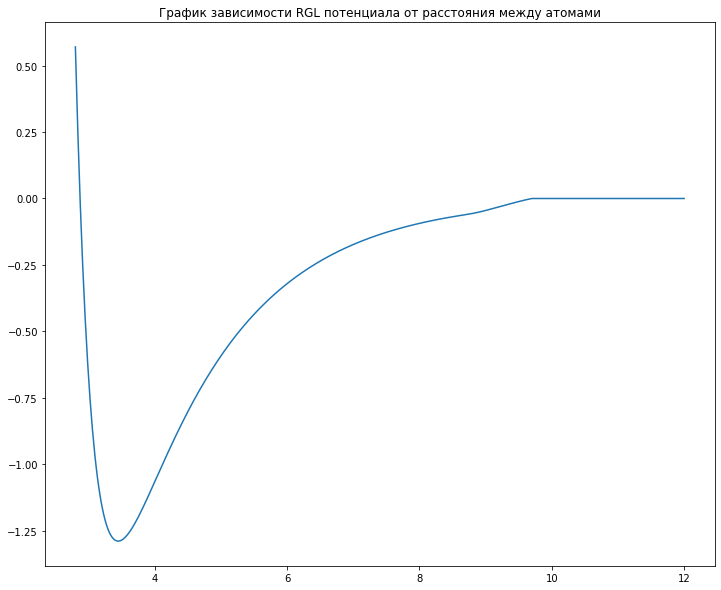

In [51]:
def f_c(r, R, D):
    if r < R - D:
        return 1
    elif R - D <= r and r < R + D:
        return 0.5 * (1 - np.sin(0.5 * np.pi * (r - R) / D))
    else:
        return 0

def rgl_potential_single(r, a, xi, p, q, r0, R, D):
        z = r / r0 - 1

        exp = np.exp(-p * z)
        fc = f_c(r, R, D)

        E_A = fc * a * exp

        exp = np.exp(-2 * q * z)
        E_R = fc * (xi ** 2) * exp

        return E_A - np.sqrt(E_R)

a, xi, p, q, r0 = best_params

r = np.linspace(2.8, 12, 500)
rgl = list(map(lambda ri: rgl_potential_single(ri, a, xi, p, q, r0, R, D), r))

fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(r, rgl, label='rgl potential')
ax.set_title('График зависимости RGL потенциала от расстояния между атомами')
print()

#### Выводы
В ходе данной лабораторной работы была проведена параметрическая идентификация RGL-потенциала для кальция (Ca). Полученный потенциал воспроизводит свойства исследуемого материала, рассчитанные с помощью квантовомеха-
нических расчётов.